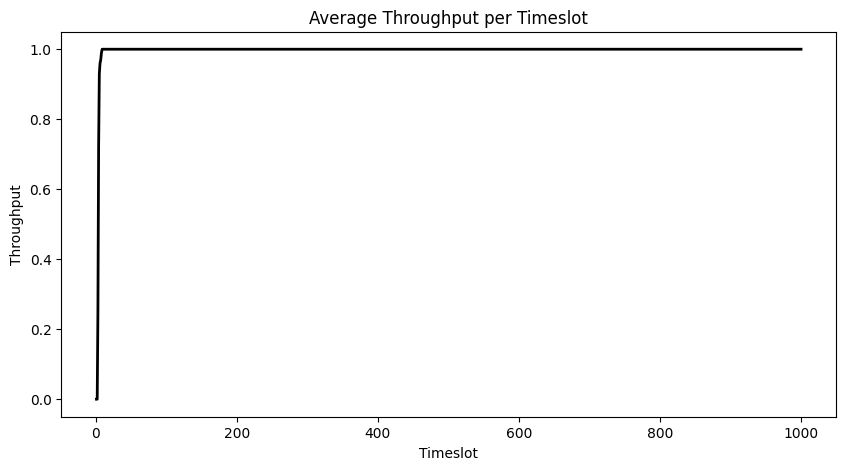

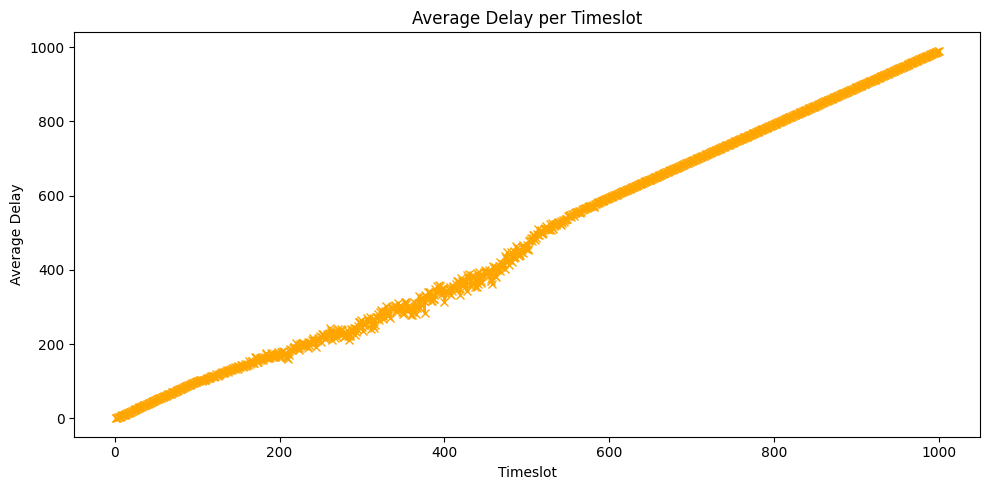

In [ ]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

class DQRAP:
    def __init__(self, n_nodes, arrival_rate, minislots = 3):
        self.n_nodes = n_nodes
        self.nodes = list(range(n_nodes))
        self.minislots = minislots
        self.arrival_rate = [0.005, 0.01, 0.05, 0.1]
        self.VTQ = deque()   #vitual transmission queue
        self.VRQ = [deque() for _ in range(minislots)]  #vitual resolution queue
        self.physical_queue = deque()
        self.new_active_node = []
        self.successful_transmission = 0
        self.packet_entry_times = {} # A dictionary to track when each packet enters contention
        self.t_sar_entry_times = {} # To track when each packet successfull contention
        self.packet_delays = []  # To store delays for successfully transmitted packets
        self.current_round = 0
        self.unique_counter = 0
        self.unique_counter_t_sar = 0
        self.delay_per_timeslot = []
        self.t_sar_per_timeslot = [] 
        self.count_transmitted_node = 0

    def generation_node(self):
        new_arrivals = []
        for node in self.nodes:
            if random.random() < self.arrival_rate:
                new_arrivals.append(node)
        for node in new_arrivals:
            while True:
                unique_key = (node, self.unique_counter)
                if unique_key not in self.packet_entry_times:
                    self.packet_entry_times[unique_key] = self.current_round
                    self.unique_counter += 1
                    break  # Đã gán thành công key mới, thoát vòng lặp
                else:
                    self.unique_counter += 1  
        return new_arrivals


    def contention_phase(self):
        active_nodes = []
        if all((len(VRQ)) == 0 for VRQ in self.VRQ):
            active_nodes.extend(self.physical_queue)
            self.physical_queue.clear()
            new_nodes = self.generation_node()
            active_nodes.extend(new_nodes)
            #print(f"Active nodes: {active_nodes}")    
        else:
             new_nodes = self.generation_node()
             self.physical_queue.extend(new_nodes)
        for i in range(self.minislots):
            if self.VRQ[i]:
                active_nodes.extend(self.VRQ[i].popleft())
                break
        slot_map = {i:[] for i in range(self.minislots)}
        for node in active_nodes:
            slot = random.randint(0, (self.minislots - 1))
            slot_map[slot].append(node)
        #print(f"Minislot: {slot_map}")
        for slot, node_list in slot_map.items():
            #print(f"Minislot {slot}: {node_list}")
            if len(node_list) == 1:
                self.VTQ.append(node_list[0])
                if node_list[0] not in self.t_sar_entry_times:
                    unique_key_t_sar = (node_list[0], self.unique_counter_t_sar)
                    self.t_sar_entry_times[unique_key_t_sar] = self.current_round
                    self.unique_counter_t_sar += 1
                #print(f"Node {node_list[0]} successful transmissted.")
            elif len(node_list) > 1:
                self.VRQ[slot].appendleft(node_list)
                #print(f"Minislot {slot}: {len(node_list)} collision nodes: {node_list}")
            #else:
                #print("No node appeared!")
        #print(f"VRQ: {self.VRQ}")
        #print(f"VTQ: {self.VTQ}")
        return len(self.VTQ), sum(len(VRQ) for VRQ in self.VRQ), active_nodes

    def resolve_collision_phase(self):
        for i in range(self.minislots):
            if self.VRQ[i]:
                #print(f"VRQ {i}: {self.VRQ[i]}")
                colliding_nodes = self.VRQ[i].popleft()
                if isinstance(colliding_nodes, list) and len(colliding_nodes) > 1:
                    self.VRQ[i].appendleft(colliding_nodes)
                    #print(f"VRQ {i} after resolved: {self.VRQ[i]}")
                else:
                    self.VTQ.append(colliding_nodes[0] if isinstance(colliding_nodes, list) else colliding_nodes)
                    #print(f"VTQ: {self.VTQ}")
                break

    def transmission_phase(self):
        current_slot_delay = 0
        current_slot_t_sar = 0
        transmitted_node = 0
        num_transmitted = 0
        num_trans = 0
        if self.VTQ:
            transmitted_node = self.VTQ.popleft()
            self.count_transmitted_node += 1
            self.successful_transmission = 1
            for key in list(self.packet_entry_times.keys()):
                if key[0] == transmitted_node:
                    delay = self.current_round - self.packet_entry_times[key]
                    self.packet_delays.append(delay)
                    #print(f'node {transmitted_node} start at timeslot {self.packet_entry_times[key]}  and contend successfully at timeslot {self.current_round}')
                    del self.packet_entry_times[key]  # remove packet from list
                    current_slot_delay = delay
                    num_transmitted = 1
                    #print(f"Delay: {current_slot_delay}")
                    break
            for key in list(self.t_sar_entry_times.keys()):
                if key[0] == transmitted_node:
                    t_sar = self.current_round - self.t_sar_entry_times[key]
                    # print(f'timeslot successfull contention: {self.t_sar_entry_times[key]}')
                    del self.t_sar_entry_times[key]  # remove packet from list
                    current_slot_t_sar = t_sar
                    num_trans = 1
                    #print(f"T_sar: {current_slot_t_sar}")
                    break
        # Store average delay for this timeslot
        avg_slot_delay = current_slot_delay / num_transmitted if num_transmitted > 0 else 0
        avg_slot_t_sar = current_slot_t_sar / num_trans if num_trans > 0 else 0
        #print(f"Avg_slot_delay: {avg_slot_delay}; avg_slot_t_sar: {avg_slot_t_sar}")

        self.delay_per_timeslot.append(avg_slot_delay)
        self.t_sar_per_timeslot.append(avg_slot_t_sar)  
        return self.count_transmitted_node, transmitted_node # One packet transmitted  
        
    def reset(self):
        self.VTQ.clear()
        self.physical_queue.clear()
        for VRQ in self.VRQ:
            VRQ.clear()
        self.successful_transmission = 0
        self.packet_entry_times.clear()
        self.t_sar_entry_times.clear()
        self.current_round = 0
        self.successful_transmission = 0
        self.packet_delays.clear()
        self.delay_per_timeslot.clear()
        self.t_sar_per_timeslot.clear()
        self.count_transmitted_node = 0
        # # thêm dòng dưới để reset delay sau mỗi trial:
        # self.current_slot_delay = 0
        # self.current_slot_t_sar = 0

    def vrq_status(self):
        minislot_groups = [[] for _ in range(self.minislots)]
        for i in range(self.minislots):
            minislot_groups[i] = list(self.VRQ[i])
        return minislot_groups

    def run_simulation(self):
        successful_contentions, collisions, active_nodes = self.contention_phase()
        self.resolve_collision_phase()
        num_transmitted, transitted_node = self.transmission_phase()

        # Get current delay for this timeslot
        current_delay = self.delay_per_timeslot[-1] if self.delay_per_timeslot else 0   # Retrieve the delay value from the most recent timeslot;
        #print(f"Current delay: {current_delay}")

        # Get current t_sar for this timeslot
        current_t_sar = current_delay - self.t_sar_per_timeslot[-1] if self.t_sar_per_timeslot else 0
        #print(f"Current t_sar: {current_t_sar}")

        if transitted_node:
            current_delay = current_delay + 1
            current_t_sar = current_t_sar + 1

        # check delay for current timeslot again
        self.current_round += 1

        if len(self.physical_queue) == 0:
            self.new_active_node.extend(active_nodes)
        return successful_contentions, collisions, num_transmitted, active_nodes, current_delay, current_t_sar       

if __name__ == "__main__":
    random.seed(42)
    dqrap = DQRAP(n_nodes=100, minislots=3, arrival_rate=1)
    num_trials = 100
    num_timeslots = 1000

    throughput_per_timeslot = [[] for _ in range(num_timeslots)]
    delay_per_timeslot = [[] for _ in range(num_timeslots)]

    for trial in range(num_trials):
        dqrap.reset()
        for i in range(num_timeslots):
            #print(f"======== Timeslot {i+1} ========")
            successful_contentions, collisions, num_transmitted, active_nodes, current_delay, current_t_sar = dqrap.run_simulation()
            #dqrap.unique_counter += 1 
            throughput = dqrap.successful_transmission
            throughput_per_timeslot[i].append(throughput)       
            delay_per_timeslot[i].append(current_delay)          # delay trung bình tại timeslot i
            #print(f"delay_per_timeslot: {delay_per_timeslot}")
    # Tính trung bình
    
    avg_throughput_per_timeslot = [sum(values) / len(values) for values in throughput_per_timeslot]
    avg_delay_per_timeslot = [sum(values) / len(values) for values in delay_per_timeslot]

    # Vẽ biểu đồ
    import matplotlib.pyplot as plt

    time_slots = list(range(1, num_timeslots + 1))
    #plt.figure(figsize=(12, 5))

    # plt.subplot(1, 2, 1)
    plt.figure(figsize=(10, 5))
    plt.plot(time_slots, avg_throughput_per_timeslot, 'k-', linewidth=2)
    plt.xlabel("Timeslot")
    plt.ylabel("Throughput")
    plt.title("Average Throughput per Timeslot")

    # plt.subplot(1, 2, 2)
    plt.figure(figsize=(10, 5))
    plt.plot(time_slots, avg_delay_per_timeslot, color='orange', marker='x')
    plt.xlabel("Timeslot")
    plt.ylabel("Average Delay")
    plt.title("Average Delay per Timeslot")

    plt.tight_layout()
    plt.show()


# # Plot figure
# plt.figure(figsize=(12, 6))
# plt.plot(time_slots, average_throughput_per_timeslot, 'kx', markersize=1)
# plt.xlabel('Timeslot')
# plt.ylabel('Throughput')
# plt.title('Simulation')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [7]:
A = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
print(len(A))

180
